In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

In [8]:

def clean_merged_data(merged_data, preference):
    ## drop the columns with all NaN values
    NaN_columns = merged_data.columns[merged_data.isnull().all()]        
    df = merged_data.drop(NaN_columns, axis=1,)[["country", preference, "age"]]

    ## replace "99 99+" with 99 and fill the missing values with 0 and convert the age variable into integer
    df["age"] = df["age"].replace({"99 99+": 99}).fillna(0).astype(int)

    return df


def random_sampling_pref(df, preference, num_iterations, fraction, replace=True):
    sampled_data = []
    for i in np.arange(1, num_iterations+1, 1):
        sample = df.groupby(['country']).apply(lambda grp: grp.sample(frac=fraction, random_state=None, replace=replace))
        sample = sample.reset_index(drop=True).groupby(['country'])[["patience"]].mean().rename(columns={'patience': f'{preference}_{i}'})
        sampled_data.append(sample)

    # Concatenate the sampled data to the result DataFrame
    df = pd.concat(sampled_data, axis=1)

    return df

# Calculate correlation (method="pearson" or "spearman")  
def generate_correlation(data, method="pearson"):
    """Calculate the measure correlation for the requested quantile group. 
    """
    corr_matrix = data.corr(method=method).values
    
    return corr_matrix[corr_matrix != 1]

In [ ]:
merged_data = pd.read_csv(r'C:\Users\Mumu\Desktop\Bonn Econ\RM_applied_micro\GIthub_new\rm-applied-micro\merged_gps_gallup.csv')

In [10]:
 # Define inputs for the MC simulation 
preference = "patience" # risktaking, altruism, trust,...
num_iterations = 1000    
fraction_population = 0.125
fraction_sample = 0.25

In [ ]:

# Clean the merged data by requesting the measurement you want
df_clean = clean_merged_data(merged_data, preference)

# Split the now "clean" merged data into two groups (using the median) by adding a new column with the assigned group number
df_clean["age_group"] = np.where(df_clean['age'] < df_clean['age'].median(), 0, 1)
df_clean.loc[df_clean["age"] == df_clean["age"].median(), "age_group"] = 1

# Random Sampling & calculate the mean for "fraction_population" by country
df_population_random_sampling_mean = random_sampling_pref(df_clean, preference, num_iterations, fraction_population, replace=True) # maybe not "replace=True"??
# Compute preference rank for "fraction_population" by country for each iteration 
df_population_random_sampling_rank = df_population_random_sampling_mean.rank(ascending=False, method='min').round().astype(pd.Int8Dtype())
# Calculate the correlation: measure correlation and rank spearman
df_population_random_sampling_corr = generate_correlation(df_population_random_sampling_mean)
df_population_random_sampling_spearman = generate_correlation(df_population_random_sampling_rank, method="spearman")

In [ ]:
# Sample randomly each age group: 0 (below 40) and 1 (above 40)
young_old_samples = {} 
young_old_ranks = {}
sample_correlations = {}
rank_correlations = {}

for label in df_clean["age_group"].unique():

        df_median_sampled = random_sampling_pref(df_clean.query(f"age_group == {label}"), preference, num_iterations, fraction_sample, replace = True)
        df_median_ranked = df_median_sampled.rank(ascending=False, method="min", axis=0)

        corr_sample = generate_correlation(df_median_sampled)
        corr_rank = generate_correlation(df_median_ranked, method="spearman")

        young_old_samples[label] = df_median_sampled
        young_old_ranks[label] = df_median_ranked
        sample_correlations[label] = corr_sample
        rank_correlations[label] = corr_rank

c:\Users\Mumu\miniforge3\envs\geokit\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mumu\miniforge3\envs\geokit\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


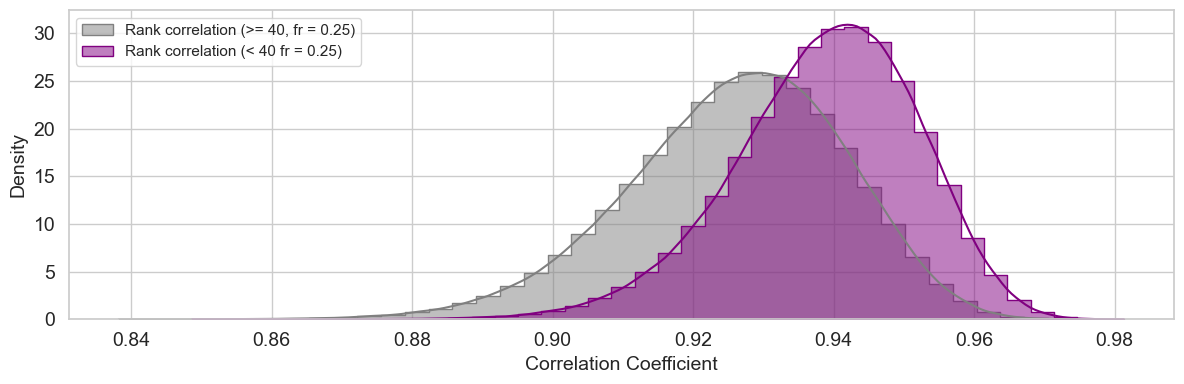

In [13]:
#plotting
sns.set(style="whitegrid")

# Create a figure and axis with seaborn
plt.figure(figsize=(12, 4))

sns.histplot(rank_correlations[1], bins=40, color='grey', kde=True, label='Rank correlation (>= 40, fr = 0.25)', element='step', stat='density')
sns.histplot(rank_correlations[0], bins=40, color='purple', kde=True, label='Rank correlation (< 40 fr = 0.25)', element='step', stat='density')
# sns.histplot(flat_corr_values_rank, bins=40, color='orange', kde=True, label='Original rank correlation (frac = 0.05)', element='step', stat='density')

# Adding labels and title
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.ylabel('Density', fontsize=14)
#plt.title('Correlation Distribution')

#xy axis font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Adding a legend
plt.legend()
#tight layout
plt.tight_layout()

#plt.savefig(r'C:\Users\Mumu\Desktop\Bonn Econ\RM_applied_micro\GIthub_new\rm-applied-micro\plots\patience_rank_correlation_median.png')